In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

# Cargar datos: genes como filas, muestras como columnas
df = pd.read_csv('TCGA-BRCA_log_FPKM.txt', sep="\t", index_col=0)

# Transponer para que las muestras sean filas (observaciones) y los genes columnas (features)
df = df.T

# Asegurar que todos los valores son numéricos
df = df.apply(pd.to_numeric, errors='coerce')

# Eliminar genes con valores faltantes
df = df.dropna(axis=1)

# Normalización de los datos por muestra (fila)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Método del codo para encontrar el número óptimo de clusters
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Método del Codo para K óptimo')
plt.show()

# Elegir el número de clusters (ajustar según gráfica)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Asignar el resultado de clustering al DataFrame original
df['Cluster'] = clusters

# Extraer identificadores por cluster
cluster_0 = df.index[df['Cluster'] == 0].tolist()
cluster_1 = df.index[df['Cluster'] == 1].tolist()
cluster_2 = df.index[df['Cluster'] == 2].tolist()

print("Cluster 0:", cluster_0)
print("Cluster 1:", cluster_1)
print("Cluster 2:", cluster_2)

# Visualizar los clusters en espacio PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters tras PCA')
plt.legend(title='Cluster')
plt.show()

# (Opcional) Cargar nuevamente el DataFrame original si lo necesitas después
df_raw = pd.read_csv('TCGA-BRCA_log_FPKM.txt', sep='\t', index_col=0)
print(df_raw.shape)
print(df_raw.head())


FileNotFoundError: [Errno 2] No such file or directory: 'TCGA-BRCA_log_FPKM.txt'

<ipython-input-46-7fac3a419ac2>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupo', y='Age at Diagnosis', data=df_completo, ax=axes[1, 0], palette='coolwarm')
<ipython-input-46-7fac3a419ac2>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupo', y='Survival Time (years)', data=df_completo, ax=axes[1, 1], palette='coolwarm')


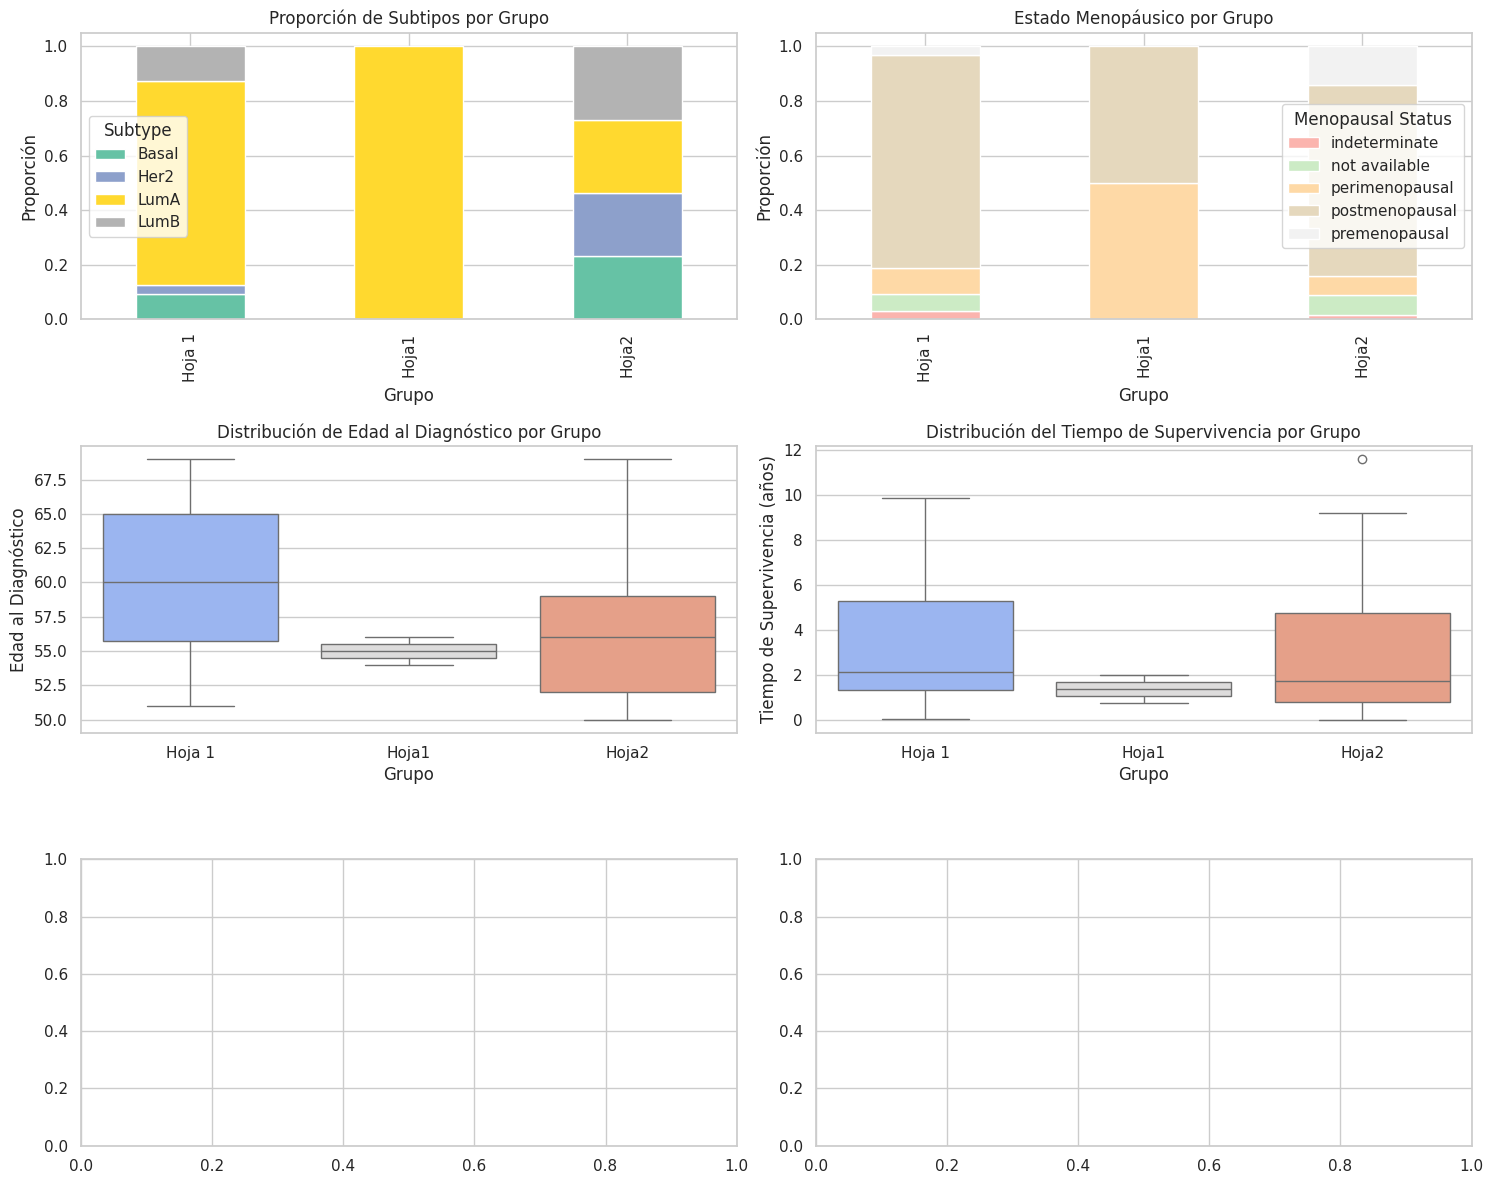

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Función para leer el archivo Excel y procesar los datos
def leer_datos(ruta_archivo):
    # Leer todas las hojas del archivo Excel
    xls = pd.ExcelFile(ruta_archivo)

    # Almacenaremos los datos por grupo
    resultados_grupos = {}

    for hoja in xls.sheet_names:
        # Leer los datos de la hoja
        df = pd.read_excel(ruta_archivo, sheet_name=hoja)

        # Limpiar los datos: eliminar filas con valores nulos en columnas clave
        df = df.dropna(subset=['Age at Diagnosis', 'Survival Time (years)', 'ER', 'PR', 'Subtype', 'Menopausal Status'])

        # Añadir una columna para identificar el grupo (nombre de la hoja)
        df['Grupo'] = hoja

        # Guardar el dataframe procesado por hoja
        resultados_grupos[hoja] = df

    return resultados_grupos

# Función para realizar análisis y graficar
def graficar_comparaciones(resultados_grupos):
    # Crear un dataframe único con todos los datos y la columna 'Grupo'
    df_completo = pd.concat(resultados_grupos.values())

    # Crear la figura para todos los gráficos en una imagen
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 filas, 2 columnas

    # Graficar proporción de subtipos por grupo
    axes[0, 0].set_title('Proporción de Subtipos por Grupo')
    subtipo_proporcion = df_completo.groupby(['Grupo', 'Subtype']).size().unstack().fillna(0)
    subtipo_proporcion = subtipo_proporcion.div(subtipo_proporcion.sum(axis=1), axis=0)  # Proporción
    subtipo_proporcion.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='Set2')
    axes[0, 0].set_xlabel('Grupo')
    axes[0, 0].set_ylabel('Proporción')

    # Graficar estado menopáusico por grupo
    axes[0, 1].set_title('Estado Menopáusico por Grupo')
    estado_menopausico = df_completo.groupby(['Grupo', 'Menopausal Status']).size().unstack().fillna(0)
    estado_menopausico = estado_menopausico.div(estado_menopausico.sum(axis=1), axis=0)  # Proporción
    estado_menopausico.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='Pastel1')
    axes[0, 1].set_xlabel('Grupo')
    axes[0, 1].set_ylabel('Proporción')

    # Graficar caja de bigotes para la edad promedio al diagnóstico
    axes[1, 0].set_title('Distribución de Edad al Diagnóstico por Grupo')
    sns.boxplot(x='Grupo', y='Age at Diagnosis', data=df_completo, ax=axes[1, 0], palette='coolwarm')
    axes[1, 0].set_xlabel('Grupo')
    axes[1, 0].set_ylabel('Edad al Diagnóstico')

    # Graficar caja de bigotes para el tiempo promedio de supervivencia
    axes[1, 1].set_title('Distribución del Tiempo de Supervivencia por Grupo')
    sns.boxplot(x='Grupo', y='Survival Time (years)', data=df_completo, ax=axes[1, 1], palette='coolwarm')
    axes[1, 1].set_xlabel('Grupo')
    axes[1, 1].set_ylabel('Tiempo de Supervivencia (años)')

    # Ajustar la figura para un buen ajuste de las subgráficas
    plt.tight_layout()

    # Mostrar todos los gráficos
    plt.show()

# Ruta del archivo Excel
ruta_archivo = 'grupos k means.xlsx'  # Cambia esto con la ruta de tu archivo Excel

# Ejecutar la lectura y procesamiento
resultados_grupos = leer_datos(ruta_archivo)

# Ejecutar el análisis y los gráficos
graficar_comparaciones(resultados_grupos)


AttributeError: 'numpy.float64' object has no attribute 'append'